### Credit Card Routing for Online Purchases via Predictive Modelling


The concept of "Credit Card Routing for Online Purchases via Predictive Modeling" involves employing machine learning models to anticipate the optimal Payment Service Provider (PSP) for a specific online credit card transaction. This prediction is made by considering diverse input features, including transaction amount, country, PSP, card type, and 3D security. The objective is to enhance the effectiveness and precision of credit card routing, ensuring that transactions are directed to the most suitable PSP. This approach aims to minimize transaction failures and maximize profits for the payment processing company.

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


#### Import data

In [2]:
# Specify the path to your Excel file
# excel_file_path = r'/data/PSP_Jan_Feb_2019.xlsx'

# Create a dictionary to hold classification metrics
classification_metrics_dict = {}

In [3]:
df = pd.read_excel('PSP_Jan_Feb_2019.xlsx')
df

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners
...,...,...,...,...,...,...,...,...
50405,50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa
50406,50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master
50407,50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master
50408,50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master


In [4]:
# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [5]:
# Display the first last rows of the DataFrame
df.tail()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
50405,50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa
50406,50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master
50407,50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master
50408,50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master
50409,50409,2019-02-28 23:48:19,Austria,91,1,Moneycard,0,Master


In [6]:
# check the shape of the dataframe
df.shape

(50410, 8)

In [7]:
# get the info about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


In [8]:
# check if there are any null values
df.isna().sum()

Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [9]:
# Verifying that the data types of the columns align with our expectations.
df.dtypes

Unnamed: 0             int64
tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object

In [10]:
# Eye balling the data
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,50410.0,25204.5,0.0,12602.25,25204.5,37806.75,50409.0,14552.257872
tmsp,50410,2019-01-29 16:28:52.923269120,2019-01-01 00:01:11,2019-01-14 12:00:36.249999872,2019-01-30 15:20:07.500000,2019-02-13 01:09:50.500000,2019-02-28 23:48:19,NaN
amount,50410.0,202.395715,6.0,133.0,201.0,269.0,630.0,96.27473
success,50410.0,0.202896,0.0,0.0,0.0,0.0,1.0,0.40216
3D_secured,50410.0,0.238266,0.0,0.0,0.0,0.0,1.0,0.426027


In [11]:
#finding unique data
df.apply(lambda x: len(x.unique()))

Unnamed: 0    50410
tmsp          50121
country           3
amount          517
success           2
PSP               4
3D_secured        2
card              3
dtype: int64

In [12]:
# drop timestamp column in order to avoid aggregation errors.
# df.drop('tmsp', axis=1, inplace=True)

In [13]:
# check for out off values in '3D_secured' column
df[df['3D_secured'] >= 2]

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card


In [14]:
df

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners
...,...,...,...,...,...,...,...,...
50405,50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa
50406,50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master
50407,50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master
50408,50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master


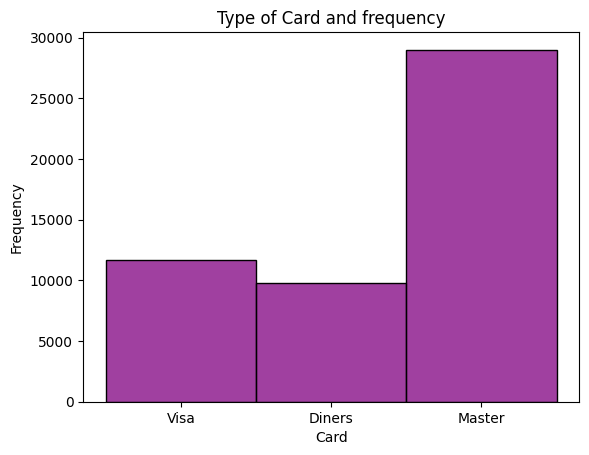

In [15]:
# 'df' is DataFrame and 'card' is the target column
sns.histplot(df['card'], bins=20, kde=False, color='purple')

# Add labels and title to the plot
plt.xlabel('Card')
plt.ylabel('Frequency')
plt.title('Type of Card and frequency')

# Show the plot
plt.show()

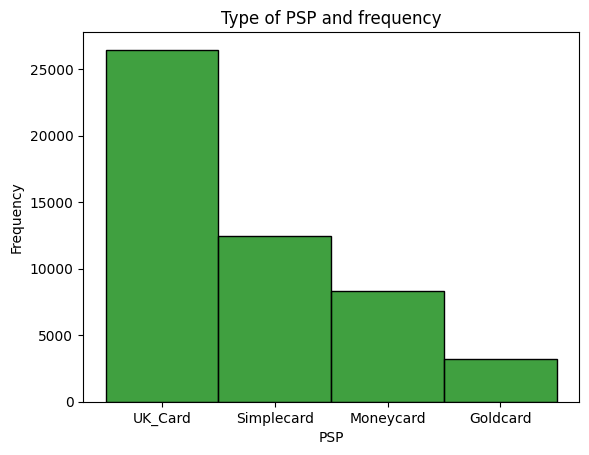

In [16]:
# 'df' is DataFrame and 'PSP' is the target column
sns.histplot(df['PSP'], bins=20, kde=False, color='green')

# Add labels and title to the plot
plt.xlabel('PSP')
plt.ylabel('Frequency')
plt.title('Type of PSP and frequency')

# Show the plot
plt.show()

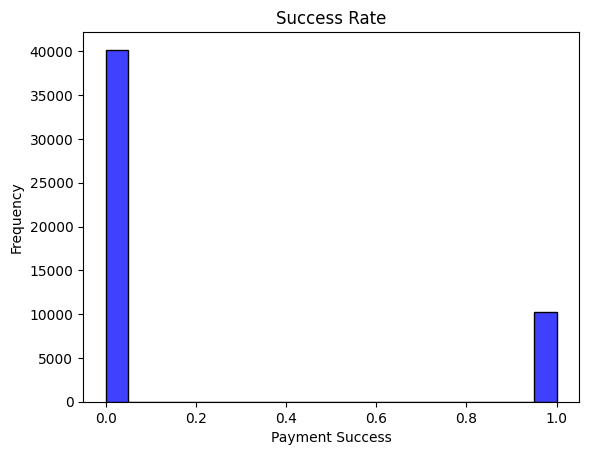

In [17]:
# 'df' is DataFrame and 'success' is the target column
sns.histplot(df['success'], bins=20, kde=False, color='blue')

# Add labels and title to the plot
plt.xlabel('Payment Success')
plt.ylabel('Frequency')
plt.title('Success Rate')

# Show the plot
plt.show()

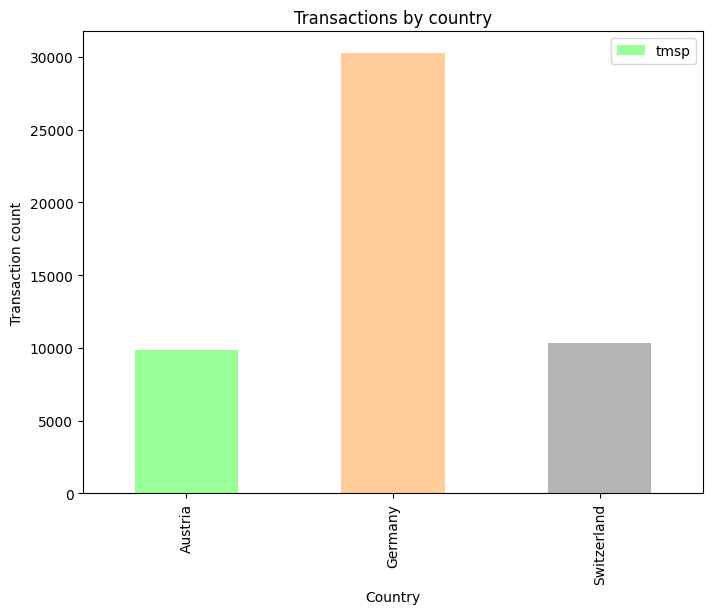

In [18]:

piv = pd.pivot_table(df, values='tmsp', index=['country'], aggfunc='count')
colors = ['#99ff99','#ffcc99','#b3b3b3']
plot = piv.plot(kind='bar',y='tmsp',  color=colors, figsize=(8, 6))
plot.set_xlabel("Country")
plot.set_ylabel("Transaction count")
plot.set_title("Transactions by country")
plt.show() 



In [19]:
piv

,tmsp
country,
Austria,9839
Germany,30233
Switzerland,10338


In [20]:
# Adding a new column to hold the attempt number
df['attempt_number'] = 0

# Calculating the attempt number for each try
for index, row in df.iterrows():
    if index > 0:
        if ((row['tmsp'] >= (df.iat[index-1,1]- timedelta(minutes=1)))&(row['country'] == df.iat[index-1,2])&(row['amount'] == df.iat[index-1,3])):
            df.iat[index,8] = df.iat[index-1,8]+1
            df.at[index, 'attempt_number'] = df.at[index-1, 'attempt_number']+1

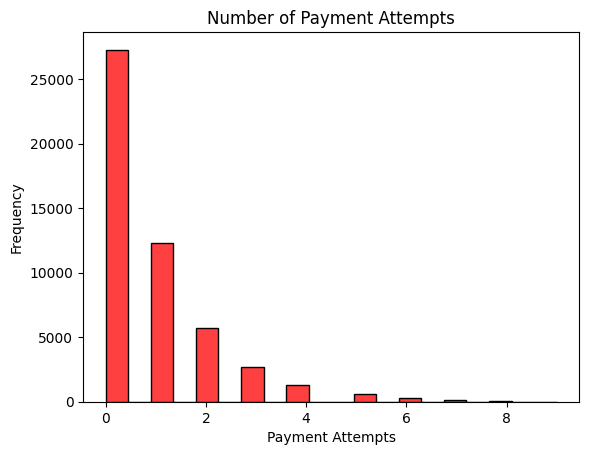

In [21]:
# 'df' is DataFrame and 'attempt_number' is the target column
sns.histplot(df['attempt_number'], bins=20, kde=False, color='red')

# Add labels and title to the plot
plt.xlabel('Payment Attempts')
plt.ylabel('Frequency')
plt.title('Number of Payment Attempts')

# Show the plot
plt.show()

In [22]:
# removing the unnamed column - which is not necessary
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)
df.shape

(50410, 8)

In [23]:

# converting timestamp to the hours and minutes
df['hour'] = df.tmsp.apply(lambda x: x.hour)
df['minute'] = df.tmsp.apply(lambda x: x.minute)

# drop the timestamp
df = df.drop(columns=['tmsp'])

In [24]:
df

,country,amount,success,PSP,3D_secured,card,attempt_number,hour,minute
0,Germany,89,0,UK_Card,0,Visa,0,0,1
1,Germany,89,1,UK_Card,0,Visa,1,0,1
2,Germany,238,0,UK_Card,1,Diners,0,0,2
3,Germany,238,1,UK_Card,1,Diners,1,0,3
4,Austria,124,0,Simplecard,0,Diners,0,0,4
...,...,...,...,...,...,...,...,...,...
50405,Switzerland,415,0,UK_Card,0,Visa,1,23,45
50406,Austria,91,0,UK_Card,0,Master,0,23,46
50407,Austria,91,0,UK_Card,0,Master,1,23,47
50408,Austria,91,0,UK_Card,0,Master,2,23,47


In [25]:
# copy the dataframe - so that we don't alter main dataframe
temp_df = df.copy()
temp_df.head()

,country,amount,success,PSP,3D_secured,card,attempt_number,hour,minute
0,Germany,89,0,UK_Card,0,Visa,0,0,1
1,Germany,89,1,UK_Card,0,Visa,1,0,1
2,Germany,238,0,UK_Card,1,Diners,0,0,2
3,Germany,238,1,UK_Card,1,Diners,1,0,3
4,Austria,124,0,Simplecard,0,Diners,0,0,4


The get_dummies function in Pandas is used to convert categorical variable(s) into dummy/indicator variables. It creates a new DataFrame with binary columns for each category/label present in the original column(s). This is particularly useful when dealing with categorical data in machine learning models.

In [26]:
temp_df = pd.get_dummies(temp_df, columns=["country", "card"])
# temp_df = temp_df.astype(int)
temp_df

,amount,success,PSP,3D_secured,attempt_number,hour,minute,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
0,89,0,UK_Card,0,0,0,1,False,True,False,False,False,True
1,89,1,UK_Card,0,1,0,1,False,True,False,False,False,True
2,238,0,UK_Card,1,0,0,2,False,True,False,True,False,False
3,238,1,UK_Card,1,1,0,3,False,True,False,True,False,False
4,124,0,Simplecard,0,0,0,4,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,415,0,UK_Card,0,1,23,45,False,False,True,False,False,True
50406,91,0,UK_Card,0,0,23,46,True,False,False,False,True,False
50407,91,0,UK_Card,0,1,23,47,True,False,False,False,True,False
50408,91,0,UK_Card,0,2,23,47,True,False,False,False,True,False


In [27]:
temp_df.dtypes

amount                  int64
success                 int64
PSP                    object
3D_secured              int64
attempt_number          int64
hour                    int64
minute                  int64
country_Austria          bool
country_Germany          bool
country_Switzerland      bool
card_Diners              bool
card_Master              bool
card_Visa                bool
dtype: object

In [28]:
X = temp_df.drop(['PSP'], axis=1)
y = temp_df['PSP']

In [29]:
# convert all boolean columns in the DataFrame to integers (0 and 1)
X.astype(int)

,amount,success,3D_secured,attempt_number,hour,minute,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
0,89,0,0,0,0,1,0,1,0,0,0,1
1,89,1,0,1,0,1,0,1,0,0,0,1
2,238,0,1,0,0,2,0,1,0,1,0,0
3,238,1,1,1,0,3,0,1,0,1,0,0
4,124,0,0,0,0,4,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50405,415,0,0,1,23,45,0,0,1,0,0,1
50406,91,0,0,0,23,46,1,0,0,0,1,0
50407,91,0,0,1,23,47,1,0,0,0,1,0
50408,91,0,0,2,23,47,1,0,0,0,1,0


#### Split data into train and test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic regression

In [31]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the 'categorical_column' using LabelEncoder
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)


# Model initialization
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.1)

# Define hyperparameters for grid search
param_grid = {'C': [0.1, 1, 10]}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model on the training set
y_train_pred = best_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')
cm_train = confusion_matrix(y_train, y_train_pred)

# Evaluate the best model on the testing set
y_test_pred = best_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix for training set
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)

# Print evaluation metrics and confusion matrix for testing set
print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

lr_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['logistic_regression'] = lr_metrics

Training set:
Accuracy: 0.525664550684388
Precision: 0.27632321984621955
Recall: 0.525664550684388
F1 Score: 0.3622332572678122
Confusion Matrix:
[[    0     0     0  2586]
 [    0     0     0  6580]
 [    0     0     0  9963]
 [    0     0     0 21199]]
Testing set:
Accuracy: 0.5217218805792502
Precision: 0.27219372067514935
Recall: 0.5217218805792502
F1 Score: 0.3577443738556714
Confusion Matrix:
[[   0    0    0  622]
 [   0    0    0 1717]
 [   0    0    0 2483]
 [   0    0    0 5260]]


c:\Users\yeswa\OneDrive\Desktop\Model engineering\case_study\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yeswa\OneDrive\Desktop\Model engineering\case_study\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decesion tree classifier

In [32]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Predict the target variable for the training and testing sets
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# Compute evaluation metrics for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')

# Compute evaluation metrics for the testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')

# Compute confusion matrix for the training and testing sets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)
print("")

print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

decision_tree_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['decision_tree'] = decision_tree_metrics


Training set:
Accuracy: 0.9993056933148184
Precision: 0.9993065141318708
Recall: 0.9993056933148184
F1 Score: 0.999305838587312
Confusion Matrix:
[[ 2586     0     0     0]
 [    2  6578     0     0]
 [    2     7  9954     0]
 [    2     5    10 21182]]

Testing set:
Accuracy: 0.3674866097996429
Precision: 0.3741163846230641
Recall: 0.3674866097996429
F1 Score: 0.3706913085023286
Confusion Matrix:
[[  51  109  144  318]
 [ 132  330  452  803]
 [ 177  435  613 1258]
 [ 362  847 1340 2711]]


### Random forest classifier

In [33]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Predict the target variable for the training and testing sets
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# Compute evaluation metrics for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')

# Compute evaluation metrics for the testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')

# Compute confusion matrix for the training and testing sets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)
print("")

print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

random_classifier_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['random_classifier'] = random_classifier_metrics


Training set:
Accuracy: 0.9993056933148184
Precision: 0.9993057052027052
Recall: 0.9993056933148184
F1 Score: 0.999305590843855
Confusion Matrix:
[[ 2582     1     1     2]
 [    1  6570     5     4]
 [    1     2  9951     9]
 [    0     1     1 21197]]

Testing set:
Accuracy: 0.4551676254711367
Precision: 0.38542356857744764
Recall: 0.4551676254711367
F1 Score: 0.4039047376034935
Confusion Matrix:
[[  19   62  110  431]
 [  37  170  310 1200]
 [  55  195  434 1799]
 [  74  345  875 3966]]


### Support vector machines

In [34]:
# Define the SVM model
svm_model = SVC(C=0.1, kernel='linear')

model = svm_model.fit(X_train_scaled, y_train)

# Define the hyperparameters to search
# param_grid = {'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 10]}

# Perform grid search
# grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5)
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_
# print(best_model)

# Evaluate the best model on the training set
y_train_pred = model.predict(X_train_scaled)  # best_model
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')
cm_train = confusion_matrix(y_train, y_train_pred)

# Evaluate the best model on the testing set
y_test_pred = model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix for training set
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)

# Print evaluation metrics and confusion matrix for testing set
print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

svm_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['support_vector_machine'] = svm_metrics

c:\Users\yeswa\OneDrive\Desktop\Model engineering\case_study\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training set:
Accuracy: 0.525664550684388
Precision: 0.27632321984621955
Recall: 0.525664550684388
F1 Score: 0.3622332572678122
Confusion Matrix:
[[    0     0     0  2586]
 [    0     0     0  6580]
 [    0     0     0  9963]
 [    0     0     0 21199]]
Testing set:
Accuracy: 0.5217218805792502
Precision: 0.27219372067514935
Recall: 0.5217218805792502
F1 Score: 0.3577443738556714
Confusion Matrix:
[[   0    0    0  622]
 [   0    0    0 1717]
 [   0    0    0 2483]
 [   0    0    0 5260]]


c:\Users\yeswa\OneDrive\Desktop\Model engineering\case_study\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient boosting classifier

In [35]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=200)
gb_model.fit(X_train_scaled, y_train)
# Define the hyperparameters to search
# param_grid = {
#    'n_estimators': [50, 100, 200],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 4, 5]
#}

# Perform GridSearchCV
# grid_search = GridSearchCV(gb_model, param_grid, cv=5)
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_
# print(best_model)

# Evaluate the best model on the training set
y_train_pred = gb_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')
cm_train = confusion_matrix(y_train, y_train_pred)

# Evaluate the best model on the testing set
y_test_pred = gb_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix for training set
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)

# Print evaluation metrics and confusion matrix for testing set
print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

gradient_boosting_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['gradient_boosting'] = gradient_boosting_metrics

Training set:
Accuracy: 0.5271523507240626
Precision: 0.5735541454904027
Recall: 0.5271523507240626
F1 Score: 0.3679190327197888
Confusion Matrix:
[[    3     0    41  2542]
 [    0    13    66  6501]
 [    0     1    85  9877]
 [    0     1    40 21158]]
Testing set:
Accuracy: 0.5222178139258083
Precision: 0.4109675298520151
Recall: 0.5222178139258083
F1 Score: 0.36159171223222
Confusion Matrix:
[[   0    0   13  609]
 [   0    2   16 1699]
 [   0    0   15 2468]
 [   0    3    9 5248]]


c:\Users\yeswa\OneDrive\Desktop\Model engineering\case_study\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGB Classifier

In [36]:
y

0           UK_Card
1           UK_Card
2           UK_Card
3           UK_Card
4        Simplecard
            ...    
50405       UK_Card
50406       UK_Card
50407       UK_Card
50408       UK_Card
50409     Moneycard
Name: PSP, Length: 50410, dtype: object

In [37]:
# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the 'categorical_column' using LabelEncoder
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Create an XGBoost classifier
clf = xgb.XGBClassifier()

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Predict the target variable for the training and testing sets
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# Compute evaluation metrics for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')

# Compute evaluation metrics for the testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')

# Compute confusion matrix for the training and testing sets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)
print("")

print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

xgb_boosting_metrics = {
    'accuracy_train': accuracy_train,
    'precision_train': precision_train,
    'recall_train': recall_train,
    'f1_score_train': f1_score_train,
    'accuracy_test' : accuracy_test,
    'precision_test': precision_test,
    'recall_test' : recall_test,
    'f1_score_test': f1_score_test
}


# Add metrics to the dictionary using model names as keys
classification_metrics_dict['xgb_boosting'] = xgb_boosting_metrics

Training set:
Accuracy: 0.5863419956357866
Precision: 0.6665126063003369
Recall: 0.5863419956357866
F1 Score: 0.49396004998922316
Confusion Matrix:
[[  312    36   127  2111]
 [   19   706   270  5585]
 [   17    60  1767  8119]
 [   28    62   248 20861]]

Testing set:
Accuracy: 0.5082324935528665
Precision: 0.39716511138955674
Recall: 0.5082324935528665
F1 Score: 0.38388524764329157
Confusion Matrix:
[[  11   14   50  547]
 [  10   42   95 1570]
 [  17   40  131 2295]
 [  18   53  249 4940]]


In [38]:
classification_metrics_dict["logistic_regression"]

{'accuracy_train': 0.525664550684388,
 'precision_train': 0.27632321984621955,
 'recall_train': 0.525664550684388,
 'f1_score_train': 0.3622332572678122,
 'accuracy_test': 0.5217218805792502,
 'precision_test': 0.27219372067514935,
 'recall_test': 0.5217218805792502,
 'f1_score_test': 0.3577443738556714}

### plots for classification metrics on testing data

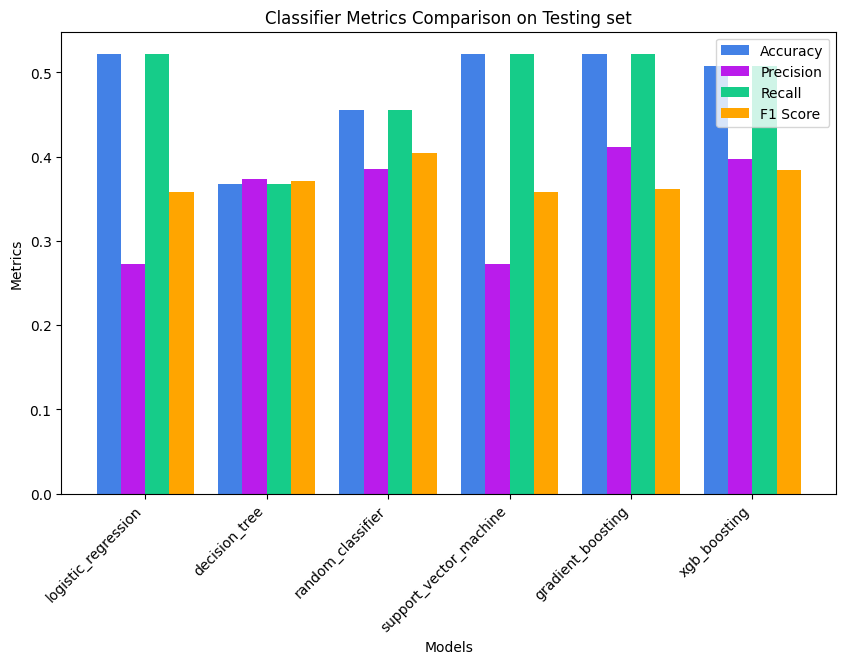

In [39]:
# Extracting model names and metric values
model_names = list(classification_metrics_dict.keys())
accuracy_values = [metrics['accuracy_test'] for metrics in classification_metrics_dict.values()]
precision_values = [metrics['precision_test'] for metrics in classification_metrics_dict.values()]
recall_values = [metrics['recall_test'] for metrics in classification_metrics_dict.values()]
f1_score_values = [metrics['f1_score_test'] for metrics in classification_metrics_dict.values()]

# Setting the positions for each group of bars
bar_width = 0.2
index = np.arange(len(model_names))

# Set the size of the plot
plt.figure(figsize=(10, 6))  # Width, Height in inches

# Plotting the bar chart
plt.bar(index, accuracy_values, width=bar_width, label='Accuracy', color='#4381e6') # blue
plt.bar(index + bar_width, precision_values, width=bar_width, label='Precision', color='#ba1ceb') # green
plt.bar(index + 2 * bar_width, recall_values, width=bar_width, label='Recall', color='#16cc89') # red
plt.bar(index + 3 * bar_width, f1_score_values, width=bar_width, label='F1 Score', color='orange') # orange

# Rotate x-axis labels vertically
# plt.xticks(rotation='vertical')
plt.xticks(rotation=45, ha='right')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Classifier Metrics Comparison on Testing set')
plt.xticks(index + 1.5 * bar_width, model_names)
plt.legend()

# Display the plot
plt.show()


In [40]:
print('Done...')

Done...
